# Multimodal RAG with CLIP Embeddings and GPT-4o


## Semi-structured and Multi-modal RAG

Many documents contain a mixture of content types, including text, tables, and images. 


With the emergence of multimodal LLMs, like [GPT-4o](https://openai.com/research/gpt-4v-system-card), it is worth considering how to utilize images in RAG.

Multimodal RAG integrates additional modalities into traditional text-based RAG, enhancing LLMs' question-answering by providing extra context and grounding textual data for improved understanding.

Adopting the approach from the [clothing matchmaker cookbook](https://cookbook.openai.com/examples/how_to_combine_gpt4v_with_rag_outfit_assistant), we directly embed images for similarity search, bypassing the lossy process of text captioning, to boost retrieval accuracy.

`Option 1:` 

* Use multimodal embeddings (such as [CLIP](https://openai.com/research/clip)) to embed images and text
* Retrieve both using similarity search
* Pass raw images and text chunks to a multimodal LLM for answer synthesis 

`Option 2:` 

* Use a multimodal LLM (such as [GPT-4o](https://openai.com/research/gpt-4v-system-card), [LLaVA](https://llava.hliu.cc/), or [FUYU-8b](https://www.adept.ai/blog/fuyu-8b)) to produce text summaries from images
* Embed and retrieve text 
* Pass text chunks to an LLM for answer synthesis 

`Option 3:` 

* Use a multimodal LLM (such as [GPT-4o](https://openai.com/research/gpt-4v-system-card), [LLaVA](https://llava.hliu.cc/), or [FUYU-8b](https://www.adept.ai/blog/fuyu-8b)) to produce text summaries from images
* Embed and retrieve image summaries with a reference to the raw image 
* Pass raw images and text chunks to a multimodal LLM for answer synthesis   




# Installations

First let's install the relevant packages.

In [ ]:
#installations
%pip install clip
%pip install torch
%pip install pillow
%pip install faiss-cpu
%pip install numpy
%pip install git+https://github.com/openai/CLIP.git
%pip install openai
%pip install matplotlib

In [5]:
# model imports
import faiss
import json
import torch
from openai import OpenAI
import torch.nn as nn
from torch.utils.data import DataLoader
import clip
# helper imports
from tqdm import tqdm
import json
import os
import numpy as np
import pickle
from typing import List, Union, Tuple

# visualisation imports
from PIL import Image
import matplotlib.pyplot as plt
import base64

# Create a sample dataset

In [ ]:
data = []
image_path = '../figures/train1.jpeg'

description_data = [
    {"image_path": "../figures/train1.jpeg", "description":"hello"},
    {"image_path": "../figures/train2.jpeg", "description":"hello"},
    {"image_path": "../figures/train3.jpeg", "description":"hello"},
    {"image_path": "../figures/train4.jpeg", "description":"hello"},
    {"image_path": "../figures/train5.jpeg", "description":"hello"},
    {"image_path": "../figures/train6.jpeg", "description":"hello"},

]
with open('description.json', 'w') as file:
    json.dump(description_data, file)
    
with open('description.json', 'r') as file:
    for line in file:
        data.append(json.loads(line))
        
data = data[0]
data

In [ ]:
import os
import json
import base64
from mimetypes import guess_type

# Function to encode a local image into a data URL
def local_image_to_data_url(image_path):
    mime_type, _ = guess_type(image_path)
    if mime_type is None:
        mime_type = "application/octet-stream"

    with open(image_path, "rb") as image_file:
        base64_encoded_data = base64.b64encode(image_file.read()).decode("utf-8")

    return f"data:{mime_type};base64,{base64_encoded_data}"


base_dir = "../"
description_data = []
path = os.path.join(base_dir, "figures")
openai_api_key = os.getenv('OPEN_AI_KEY')
client = OpenAI(api_key = openai_api_key)

if os.path.isdir(path):
    for image_file in os.listdir(path):
        image_path = os.path.join(path, image_file)
        try:
            data_url = local_image_to_data_url(image_path)
            
            response = client.chat.completions.create(
                model="gpt-4o",
                messages=[
                    {
                        "role": "user",
                        "content": [
                            {
                                "type": "text",
                                "text": "You are tasked with summarizing the description of the images. Give a concise summary of the images provided to you."
                            },
                            {
                                "type": "image_url",
                                "image_url": {
                                    "url": data_url
                                }
                            }
                        ]
                    }
                ],
                max_tokens=30
            )
            
            content = response.choices[0].message.content
            
            description_data.append({
                "image_path": image_path,
                "description": content
            })
        
        except Exception as e:
            print(f"Error processing image {image_path}: {e}")

with open('description.json', 'w') as file:
    json.dump(description_data, file, indent=4)

description_data

# Option 1


We will now:
1.   Create the image embedding database
2.   Set up a query to the multimodal model
3.   Perform the semantic search
4.   Pass a user query


Let's load the CLIP model.

In [ ]:
#load model on device. The device you are running inference/training on is either a CPU or GPU if you have.
os.environ["OMP_NUM_THREADS"] = "1" # <-- this is only to make clip compatible for mac users
device = "cpu"
model, preprocess = clip.load("ViT-B/32",device=device)

## Create image embedding database

Next we will create our image embeddings knowledge base from a directory of images. This will be the knowledge base of technology that we search through to provide information to the user for an image they upload.

We pass in the directory in which we store our images (as JPEGs) and loop through each to create our embeddings.

We also have a file `description.json`. This has an entry for every single image in our knowledge base. It has two keys: `image_path` and `description`. It maps each image to a useful description of this image to aid in answering the user question.

First let's write a function to get all the image paths in a given directory. We will then get all the jpeg's from a directory called `image_database`

In [72]:
def get_image_paths(directory: str, number: int = None) -> List[str]:
    image_paths = []
    count = 0
    for filename in os.listdir(directory):
        image_paths.append(os.path.join(directory, filename))
        if number is not None and count == number:
            return [image_paths[-1]]
        count += 1
    return image_paths

image_directory = '../figures/'
image_paths = get_image_paths(image_directory)

Next we will write a function to get the image embeddings from the CLIP model given a series of paths.

We first preprocess the image using the preprocess function we got from `clip` earlier. This performs a few things to ensure the input to the CLIP model is of the right format and dimensionality including resizing, normalization, colour channel adjustment etc.

We then stack these preprocessed images together so we can pass them into the model at once rather than in a loop. And finally return the model output which is an array of embeddings.

In [74]:
def get_features_from_image_path(image_paths):
    images = [preprocess(Image.open(image_path).convert("RGB")) for image_path in image_paths]
    image_input = torch.tensor(np.stack(images))
    with torch.no_grad():
        image_features = model.encode_image(image_input).float()
    return image_features

image_features = get_features_from_image_path(image_paths)


We can now create our vector database using `faiss`.

In [75]:
index = faiss.IndexFlatIP(image_features.shape[1])
index.add(image_features)

We also create a helper function to retrieve the description of a reference image. 

In [39]:
def find_entry(data, key, value):
    for entry in data:
        if entry.get(key) == value:
            return entry
    return None

Let us display an example image, this will be the user uploaded image. This is a piece of tech that was unveiled at the 2024 CES. It is the DELTA Pro Ultra Whole House Battery Generator.

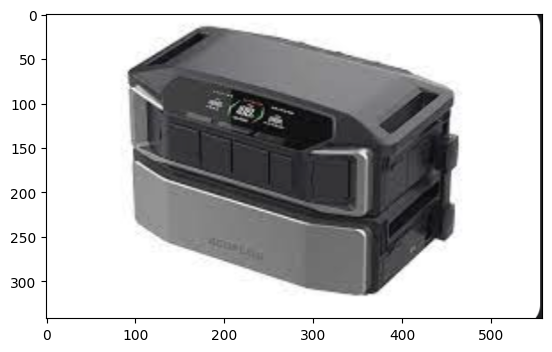

In [77]:
im = Image.open(image_path)
plt.imshow(im)
plt.show()

## Querying the GPT4o model

Now let's have a look at what GPT-4o (which wouldn't have seen this technology before) will label it as.



First we will need to write a function to encode our image in base64 as this is the format we will pass into the multimodal model. Then we will create a generic `image_query` function to allow us to query the LLM with an image input.

In [78]:
def encode_image(image_path):
    with open(image_path, 'rb') as image_file:
        encoded_image = base64.b64encode(image_file.read())
        return encoded_image.decode('utf-8')

def image_query(query, image_path):
    response = client.chat.completions.create(
        model='gpt-4o',
        messages=[
            {
            "role": "user",
            "content": [
                {
                "type": "text",
                "text": query,
                },
                {
                "type": "image_url",
                "image_url": {
                    "url": f"data:image/jpeg;base64,{encode_image(image_path)}",
                },
                }
            ],
            }
        ],
        max_tokens=300,
    )
    # Extract relevant features from the response
    return response.choices[0].message.content

image_query('Write a short label of what is shown in this image?', image_path)

'Portable power station with multiple ports for charging devices.'

## Performing semantic search

Now let's perform similarity search to find the two most similar images in our knowledge base. We do this by getting the embeddings of a user inputted `image_path`, retrieving the indexes and distances of the similar iamges in our database. Distance will be our proxy metric for similarity and a smaller distance means more similar. We then sort based on distance in descending order.

In [80]:
image_search_embedding = get_features_from_image_path([image_path])
distances, indices = index.search(image_search_embedding.reshape(1, -1), 2) #2 signifies the number of topmost similar images to bring back
distances = distances[0]
indices = indices[0]
indices_distances = list(zip(indices, distances))
indices_distances.sort(key=lambda x: x[1], reverse=True)

We require the indices as we will use this to serach through our image_directory and selecting the image at the location of the index to feed into the multimodal model for RAG.

And let's see what it brought back (we display these in order of similarity):

5


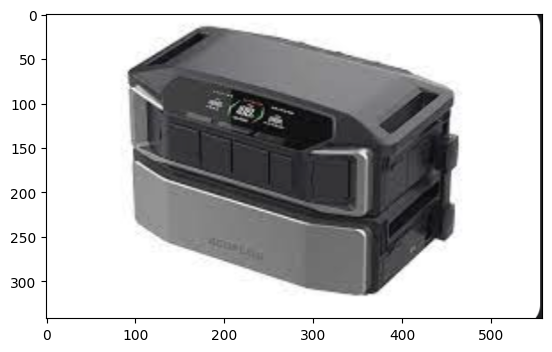

0


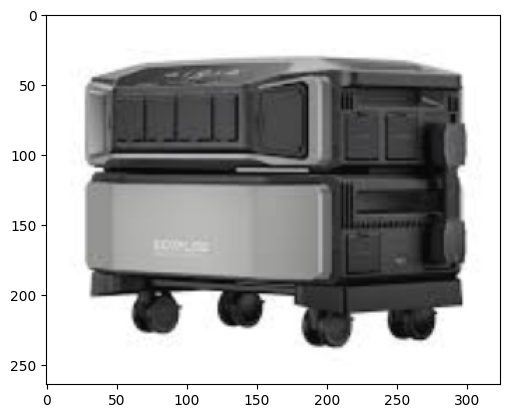

In [81]:
#display similar images
for idx, distance in indices_distances:
    print(idx)
    path = get_image_paths(image_directory, idx)[0]
    im = Image.open(path)
    plt.imshow(im)
    plt.show()

We can see here it brought back two images which contain the DELTA Pro Ultra Whole House Battery Generator.

## User querying the most similar image

Now for our most similar image, we want to pass it and the description of it to gpt-4o with a user query so they can inquire about the technology that they may have bought.

In [84]:
similar_path = get_image_paths(image_directory, indices_distances[0][0])[0]
element = find_entry(description_data, 'image_path', similar_path)

user_query = 'What is this item supposed to do?'
prompt = f"""
Below is a user query, I want you to answer the query using the description and image provided.

user query:
{user_query}

description:
{element['description']}
"""
image_query(prompt, similar_path)

'This item is a portable refrigerator or cooler designed for travel. It features a dual-tiered structure and a digital control panel, allowing users to store and cool items like food and beverages while on the go, maintaining them at specific temperatures.'

# Option 2

First, we create a vectorstore using the text description of the image. We will use 
'text-embedding-3-small' as the embedding model

In [88]:
import uuid
from langchain.retrievers.multi_vector import MultiVectorRetriever
from langchain.storage import InMemoryStore
from langchain_chroma import Chroma
from langchain_core.documents import Document
from langchain_openai import OpenAIEmbeddings

# Initialize embeddings
embeddings = OpenAIEmbeddings(model="text-embedding-3-small", api_key = openai_api_key)

# Create vectorstore for summaries
vectorstore = Chroma(
    collection_name="image_summaries", 
    embedding_function=embeddings
)

# Create storage for original data
store = InMemoryStore()
id_key = "image_id"

# Initialize the retriever
retriever = MultiVectorRetriever(
    vectorstore=vectorstore,
    docstore=store,
    id_key=id_key,
)

# Process your description_data
image_ids = [str(uuid.uuid4()) for _ in description_data]

# Create summary documents
summary_docs = [
    Document(
        page_content=item["description"],
        metadata={
            id_key: image_ids[i],
            "image_path": item["image_path"]
        }
    )
    for i, item in enumerate(description_data)
]

# Add summaries to vectorstore
retriever.vectorstore.add_documents(summary_docs)

# Store original data
original_data = [(id_, item) for id_, item in zip(image_ids, description_data)]
retriever.docstore.mset(original_data)

Now given user query, get relevant text descriptions using the Retriever


In [103]:
similar_docs = retriever.invoke("portable refrigerator for travelling")[0]
similar_docs

{'image_path': '../figures/train2.jpeg',
 'description': 'The image shows a compact, dual-tiered portable refrigerator or cooler with a digital control panel on the top section. It appears to be designed for travel'}

Now for our most similar image summary/description, we want to pass the description and to gpt-4o with a user query so they can inquire about the technology

In [105]:
def text_query(query, description):
    response = client.chat.completions.create(
        model='gpt-4o',
        messages=[
            {
                "role": "user",
                "content": [
                    {
                        "type": "text",
                        "text": query + "\n\nContext: " + description
                    }
                ]
            }
        ],
        max_tokens=30,
    )
    return response.choices[0].message.content

user_query = 'What is this item supposed to do?'
prompt = f"""
Below is a user query, I want you to answer the query using the description provided.

user query:
{user_query}

description:
{similar_docs['description']}
"""

# Generate response using only text
text_query(prompt, similar_docs['description'])

"This item is a portable refrigerator or cooler that is designed to keep your food and beverages cool while you're on the move. It features a dual-tiered"

# Option 3

We use the same retriever as in option 2. 

In [104]:
def text_image_query(query, image_path, description):
    response = client.chat.completions.create(
        model='gpt-4o',
        messages=[
            {
                "role": "user",
                "content": [
                    {
                        "type": "text",
                        "text": query,
                    },
                    {
                        "type": "image_url",
                        "image_url": {
                            "url": f"data:image/jpeg;base64,{encode_image(image_path)}",
                        }
                    }
                ]
            }
        ],
        max_tokens=300,
    )
    return response.choices[0].message.content


user_query = 'What is this item supposed to do?'
prompt = f"""
Below is a user query, I want you to answer the query using the description provided.

user query:
{user_query}

description:
{similar_docs['description']}
"""

# Generate response using the query and image, but not the stored description
text_image_query(prompt, image_path,{similar_docs['description']} )

'The item is a compact, dual-tiered portable refrigerator or cooler designed for travel. It features a digital control panel on the top, which allows users to adjust settings for cooling food and beverages while on the go.'

# Take-away

Option 1: Uses multimodal embeddings for retrieval and multimodel LLM for generation.   

Option 2: using multimodal LLM to converts images to text summaries and uses a text-only embedding model for retrieval. Uses a text-only LLM (not multimodal) to generate the response, relying solely on text summaries without the original images.  

Option 3: Similar to Option 2 for retrieval, but retains access to the original images and use multimodal LLM at generation.